# Imports

In [ ]:
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn.svm import NuSVR
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.metrics import mean_squared_error

In [ ]:
def evaluation_metrics(y_test, y_pred, x_trn, n):
  R2 = metrics.r2_score(y_test, y_pred).round(4)
  Adjusted_R2 = (1 - (1-metrics.r2_score(y_test, y_pred))*(len(y_test)-1)/(len(y_test)-x_trn.shape[1]-1)).round(4)
  MAE = metrics.mean_absolute_error(y_test, y_pred).round(4)
  MSE = metrics.mean_squared_error(y_test, y_pred).round(4)
  RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred)).round(4)
  Pearson_Correlation = pearsonr(y_test, y_pred)[0].round(4)

  evaluation_table = pd.DataFrame.from_dict({"feature": n,
                                            "R^2": R2,
                                            "Adjusted R^2": Adjusted_R2,
                                            "MAE": MAE,
                                            "MSE": MSE,
                                            "RMSE": RMSE,
                                            "Pearson_Correlation": [Pearson_Correlation],
                                            }, 
  )

  return evaluation_table

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
training_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/training_impute_median_norm.csv')
testing_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/testing_impute_median_norm.csv')
validation_impute_median_norm = pd.read_csv('/content/drive/MyDrive/ML Project/Data for modeling/median imputer/validation_impute_median_norm.csv')

In [ ]:
x_trn = training_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_trn = training_impute_median_norm['slope_following_9_months']
x_tst = testing_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_tst = testing_impute_median_norm['slope_following_9_months']
x_val = validation_impute_median_norm.drop(columns=['subject_id','slope_following_9_months'])
y_val = validation_impute_median_norm['slope_following_9_months']

In [ ]:
data_all = training_impute_median_norm.append(testing_impute_median_norm).append(validation_impute_median_norm)
data_all = data_all.reset_index()
data = training_impute_median_norm.append(testing_impute_median_norm)
X = x_trn.append(x_tst)
y = y_trn.append(y_tst)

In [ ]:
top_feature_lasso = ['SymOnsetDelta', 'fvc_liters_ValueLast', 'slope_first_3_months',
       'OnsetDelta', 'BMI_slope', 'Basophils_ValueSd',
       'AbsoluteBasophilCount_ValueMax', 'Respiratory_Rate_sd',
       'Chloride_ValueMin', 'fvc_liters_ValueStd', 'Neutrophils_TestNum',
       'Chloride_ValueSd', 'Potassium_ValueMin', 'Pulse_sd',
       'Basophils_ValueMax', 'Bicarbonate_ValueAve', 'BMI_last',
       'Phosphorus_ValueMin', 'Temperature_sd', 'Lymphocytes_ValueAve',
       'Temperature_max', 'Glucose_ValueMin', 'Temperature_nmeas',
       'Phosphorus_ValueAve', 'Vital_Signs_Delta_last', 'Pulse_min',
       'Respiratory_Rate_min', 'WhiteBloodCellWBC_ValueAve',
       'ALSFRS_Total_3_month', 'BilirubinTotal_ValueMin']

# NuSVR default

In [ ]:
sklearn.svm.NuSVR(
    nu = 0.5,
    kernel ='rbf',
    degree = 3,
    gamma ='scale',
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    shrinking = True,
    cache_size = 200,
    verbose = False,
    max_iter = -1
)

NuSVR()

In [ ]:
start_NuSVR = time()
regr = NuSVR(    
    nu = 0.5,
    kernel ='rbf',
    degree = 3,
    gamma ='scale',
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    shrinking = True,
    cache_size = 200,
    verbose = False,
    max_iter = -1)
regr.fit(x_trn,y_trn)
y_pred = regr.predict(x_tst)
runtime_NuSVR = np.round(time()-start_NuSVR,5)
print("NuSVR", runtime_NuSVR,"sec")
print(evaluation_metrics(y_tst, y_pred, x_tst,len(x_trn.columns)))

NuSVR 0.71414 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.1111        -2.721  0.5503  0.6287  0.7929               0.3405


In [ ]:
start_NuSVR = time()
regr.fit(X,y)
y_pred_val = regr.predict(x_val)
runtime_NuSVR = np.round(time()-start_NuSVR,5)
print("NuSVR", runtime_NuSVR,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))

NuSVR 1.23274 sec
   feature     R^2  Adjusted R^2     MAE    MSE    RMSE  Pearson_Correlation
0      325  0.1025       -0.2987  0.6136  0.833  0.9127               0.3298


# NuSVR top 30 lasso features

In [ ]:
x_trn_top = x_trn[top_feature_lasso]
x_tst_top = x_tst[top_feature_lasso]

In [ ]:
start_NuSVR_top = time()
regr = NuSVR(    
    nu = 0.5,
    kernel ='rbf',
    degree = 3,
    gamma ='scale',
    coef0 = 0.0,
    tol = 0.001,
    C = 1.0,
    shrinking = True,
    cache_size = 200,
    verbose = False,
    max_iter = -1)
regr.fit(x_trn_top,y_trn)
y_pred_top = regr.predict(x_tst_top)
runtime_NuSVR_top = np.round(time()-start_NuSVR_top,5)
print("NuSVR", runtime_NuSVR_top,"sec")
print(evaluation_metrics(y_tst, y_pred_top, x_tst_top,len(x_trn_top.columns)))

NuSVR 0.32257 sec
   feature     R^2  Adjusted R^2     MAE    MSE    RMSE  Pearson_Correlation
0       30  0.1263        0.0603  0.5419  0.618  0.7861               0.3629


# Hyper Parameters

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV


NuSVR_params = {
    'nu' : [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'C' : [0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5],
    'gamma' : ['scale','auto'],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
}
NuSVR_model = NuSVR()

grid_search = GridSearchCV(estimator = NuSVR_model, param_grid = NuSVR_params, 
                           cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


GridSearchCV(cv=3, estimator=NuSVR(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             verbose=2)

In [ ]:
results = pd.DataFrame.from_dict(grid_search.cv_results_)

In [ ]:
results.loc[results['mean_test_score'].idxmax()]['params']

{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf', 'nu': 0.5}

## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
NuSVR_params = {
    'nu' : [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'C' : [0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5],
    'gamma' : ['scale','auto'],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
    #'kernel' : ['poly', 'rbf', 'sigmoid']
}

NuSVR_model = NuSVR()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2021)

NuSVR_clf = RandomizedSearchCV(estimator=NuSVR_model,
                             param_distributions=NuSVR_params,
                             scoring='neg_mean_squared_error', 
                             cv = cv,    
                             random_state=2021,               
                             n_iter=5,
                             verbose=1    
)

NuSVR_clf.fit(X,y)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=2021),
                   estimator=NuSVR(), n_iter=5,
                   param_distributions={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0,
                                              1.5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'nu': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                               0.8, 0.9, 1.0]},
                   random_state=2021, scoring='neg_mean_squared_error',
                   verbose=1)

In [ ]:
print("Best parameters:", NuSVR_clf.best_params_)

Best parameters: {'nu': 0.4, 'kernel': 'rbf', 'gamma': 'auto', 'C': 0.2}


# Output


In [ ]:
#tuned training
start_NuSVR = time()
regr = NuSVR(    
    nu = 0.5,
    kernel ='rbf',
    degree = 3,
    gamma ='auto',
    coef0 = 0.0,
    tol = 0.001,
    C = 0.5,
    shrinking = True,
    cache_size = 200,
    verbose = False,
    max_iter = -1)
regr.fit(x_trn,y_trn)
y_pred_train = regr.predict(x_trn)
y_pred_test = regr.predict(x_tst)
runtime_NuSVR = np.round(time()-start_NuSVR,5)
print("NuSVR", runtime_NuSVR,"sec")
print(evaluation_metrics(y_tst, y_pred_test, x_tst,len(x_trn.columns)))

NuSVR 1.07425 sec
   feature   R^2  Adjusted R^2     MAE     MSE   RMSE  Pearson_Correlation
0      325  0.12       -2.6837  0.5474  0.6224  0.789               0.3628


In [ ]:
#tuned testing
start_NuSVR = time()

regr.fit(X,y)
y_pred_val = regr.predict(x_val)
runtime_NuSVR = np.round(time()-start_NuSVR,5)
print("NuSVR", runtime_NuSVR,"sec")
print(evaluation_metrics(y_val, y_pred_val, x_val,len(x_val.columns)))

NuSVR 1.07694 sec
   feature     R^2  Adjusted R^2     MAE     MSE    RMSE  Pearson_Correlation
0      325  0.1042       -0.2962  0.6124  0.8314  0.9118               0.3418


In [ ]:
#output y
output_y = pd.DataFrame.from_dict({
    "subject_id": data_all['subject_id'],
    "y_pred": np.append(np.append(y_pred_train,y_pred_test),y_pred_val),
    "y_true": data_all['slope_following_9_months']
})
output_y = output_y.reset_index().drop(columns='index')
output_y

,subject_id,y_pred,y_true
0,553099,-0.706291,-0.887366
1,8471,-1.281952,-0.954460
2,534458,-0.901505,-0.521771
3,225766,-0.782182,-0.454279
4,161271,-0.692368,-0.457694
...,...,...,...
3186,993900,-0.796821,-0.699693
3187,994973,-0.736397,-0.385274
3188,995546,-0.696018,-0.378880
3189,996401,-0.428864,-1.104556


In [ ]:
output_y.to_csv("/content/drive/MyDrive/ML Project/Output/NuSVR_output.csv")

In [ ]:
output_y.describe()

,subject_id,y_pred,y_true
count,3191.000000,3191.000000,3191.000000
mean,499666.061736,-0.781365,-0.857436
std,291684.227591,0.276547,0.944191
min,329.000000,-1.894830,-8.056765
25%,246779.500000,-0.962045,-1.257713
50%,499325.000000,-0.767225,-0.691742
75%,752560.000000,-0.586098,-0.252065
max,999990.000000,0.145488,7.609167


# Visualization

In [ ]:
MSE = metrics.mean_squared_error(output_y['y_true'], output_y['y_pred']).round(4)
MSE

0.7018

In [ ]:
Pearson_Correlation = pearsonr(output_y['y_true'], output_y['y_pred'])[0].round(4)
Pearson_Correlation

0.5204

Text(0, 0.5, 'y_true')

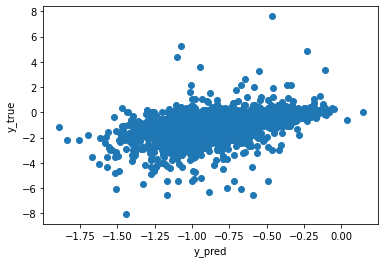

In [ ]:
plt.scatter(output_y['y_pred'], output_y['y_true'])
plt.xlabel("y_pred")
plt.ylabel("y_true")

# Without outliers

In [ ]:
from scipy import stats
z = np.abs(stats.zscore(data_all['slope_following_9_months']))
z

array([0.03170424, 0.1027747 , 0.35556102, ..., 0.50692257, 0.26176806,
       0.35556102])

In [ ]:
threshold = 3
outliers = np.where(z > threshold)[0]
outliers

array([  51,   62,   82,  133,  146,  179,  246,  247,  507,  607,  694,
        722,  734,  752,  755,  821,  855,  874,  880,  924,  985, 1046,
       1088, 1187, 1321, 1324, 1398, 1406, 1444, 1541, 1568, 1592, 1609,
       1622, 1700, 1736, 1829, 1868, 1879, 1936, 2205, 2258, 2411, 2433,
       2482, 2557, 2572, 2592, 2677, 2711, 2724, 2725, 2749, 2756, 2809,
       3013, 3050])

In [ ]:
len(outliers)

57

In [ ]:
output_y.iloc[outliers.tolist(),:]

,subject_id,y_pred,y_true
51,303218,-1.507320,-6.087333
62,380751,-1.007110,2.174048
82,330665,-0.836943,-3.804583
133,770063,-1.232123,-3.726939
146,525197,-0.998286,-5.435119
179,151434,-1.516714,-4.782905
246,230778,-1.273484,-3.726939
247,295093,-1.204686,-3.985754
507,584290,-0.599876,-4.348095
607,340898,-1.075794,5.247701


In [ ]:
output_no_outliers = output_y.drop(index=outliers)
output_no_outliers

,subject_id,y_pred,y_true
0,553099,-0.706291,-0.887366
1,8471,-1.281952,-0.954460
2,534458,-0.901505,-0.521771
3,225766,-0.782182,-0.454279
4,161271,-0.692368,-0.457694
...,...,...,...
3186,993900,-0.796821,-0.699693
3187,994973,-0.736397,-0.385274
3188,995546,-0.696018,-0.378880
3189,996401,-0.428864,-1.104556


In [ ]:
MSE = metrics.mean_squared_error(output_no_outliers['y_true'], output_no_outliers['y_pred']).round(4)
MSE

0.4272

In [ ]:
Pearson_Correlation = pearsonr(output_no_outliers['y_true'], output_no_outliers['y_pred'])[0].round(4)
Pearson_Correlation

0.5622